<a href="https://colab.research.google.com/github/valvarezma/vision_artificial/blob/main/template_maching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Instalar Librerias de OpenCV Jupyter

In [ ]:
%%capture
!apt install libopencv-dev
!pip install nvcc4jupyter
%load_ext nvcc4jupyter

import os
import subprocess
from IPython.display import Image
COMPILER_ARGS = subprocess.check_output(["pkg-config", "--cflags", "--libs", "opencv4"]).decode().strip()
print(COMPILER_ARGS)

import os
import subprocess
from IPython.display import Image
import shutil

IMG_SIZE = 400
os.environ["IMG_SIZE"] = str(IMG_SIZE)
IMG_FNAME = "image.jpg"
os.environ["IMG_FNAME"] = IMG_FNAME

!wget -O $IMG_FNAME https://picsum.photos/$IMG_SIZE.jpg &> /dev/null
Image(filename=IMG_FNAME)
shutil.copyfile(IMG_FNAME, "imagen_2.jpg")

Blurring de una imagen en Cuda

In [19]:

%%cuda --compiler-args "$COMPILER_ARGS"

#include <opencv2/core.hpp>
#include <opencv2/imgcodecs.hpp>

#include <iostream>

#define BLUR_SIZE 5
#define R 0
#define G 1
#define B 2

// error checking macro
#define cudaCheckErrors(msg) \
    do { \
        cudaError_t __err = cudaGetLastError(); \
        if (__err != cudaSuccess) { \
            fprintf(stderr, "Fatal error: %s (%s at %s:%d)\n", \
                msg, cudaGetErrorString(__err), \
                __FILE__, __LINE__); \
            fprintf(stderr, "*** FAILED - ABORTING\n"); \
            exit(1); \
        } \
    } while (0)

// kernel taken from https://stackoverflow.com/a/65973288
__global__ void blurKernel(
    unsigned char* in,
    unsigned char* out,
    int width,
    int height,
    int num_channel,
    int channel
) {

    int col = blockIdx.x * blockDim.x + threadIdx.x;
    int row = blockIdx.y * blockDim.y + threadIdx.y;

    if(col < width && row < height) {
        int pixVal = 0;
        int pixels = 0;
        for(int blurRow = -BLUR_SIZE; blurRow < BLUR_SIZE + 1; ++blurRow) {
            for(int blurCol = -BLUR_SIZE; blurCol < BLUR_SIZE + 1; ++blurCol) {
                int curRow = row + blurRow;
                int curCol = col + blurCol;
                if(curRow > -1 && curRow < height && curCol > -1 && curCol < width) {
                    pixVal += in[curRow * width * num_channel + curCol * num_channel + channel];
                    pixels++;
                }
            }
        }
        out[row * width * num_channel + col * num_channel + channel] = (unsigned char)(pixVal/pixels);
    }
}

int main()
{

    std::string image_path = cv::samples::findFile("image_1.jpg");
    cv::Mat img = imread(image_path, cv::IMREAD_COLOR);
    if(img.empty())
    {
        std::cerr << "Could not read the image: " << image_path << std::endl;
        return 1;
    }

    // image shape
    int width = img.cols;
    int height = img.rows;
    int n_channels = 3; // hard-coded RGB processing

    // we will read and write directly into the data array of the OpenCV Matrix
    unsigned char *host_image_input = img.data;
    unsigned char *host_image_output = img.data;

    // allocate memory for device arrays
    unsigned char* dev_image_input = NULL;
    unsigned char* dev_image_output = NULL;
    cudaMalloc(
        (void**)&dev_image_input,
        sizeof(unsigned char) * height * width * n_channels
    );
    cudaMalloc(
        (void**)&dev_image_output,
        sizeof(unsigned char) * height * width * n_channels
    );
    cudaCheckErrors("cudaMalloc failure");

    // transfer data from host to device for processing on GPU
    cudaMemcpy(
        dev_image_input,
        host_image_input,
        sizeof(unsigned char) * height * width * n_channels,
        cudaMemcpyHostToDevice
    );
    cudaCheckErrors("cudaMemcpy H2D failure");

    // run a blur kernel on each channel
    dim3 blockSize(16, 16, 1);
    dim3 gridSize(width/blockSize.x, height/blockSize.y, 1);
    blurKernel<<<gridSize, blockSize>>>(dev_image_input, dev_image_output, width, height, n_channels, R);
    blurKernel<<<gridSize, blockSize>>>(dev_image_input, dev_image_output, width, height, n_channels, G);
    blurKernel<<<gridSize, blockSize>>>(dev_image_input, dev_image_output, width, height, n_channels, B);

    cudaDeviceSynchronize();
    cudaCheckErrors("kernel failure");

    // copy results back to host
    cudaMemcpy(
        host_image_output,
        dev_image_output,
        sizeof(unsigned char) * height * width * n_channels,
        cudaMemcpyDeviceToHost
    );
    cudaCheckErrors("cudaMemcpy D2H failure");

    cudaFree(dev_image_input);
    cudaFree(dev_image_output);

    // save the blurred image to disk
    cv::imwrite("image_blurred.jpg", img);

    return 0;
}

Visualización de resultados blurred

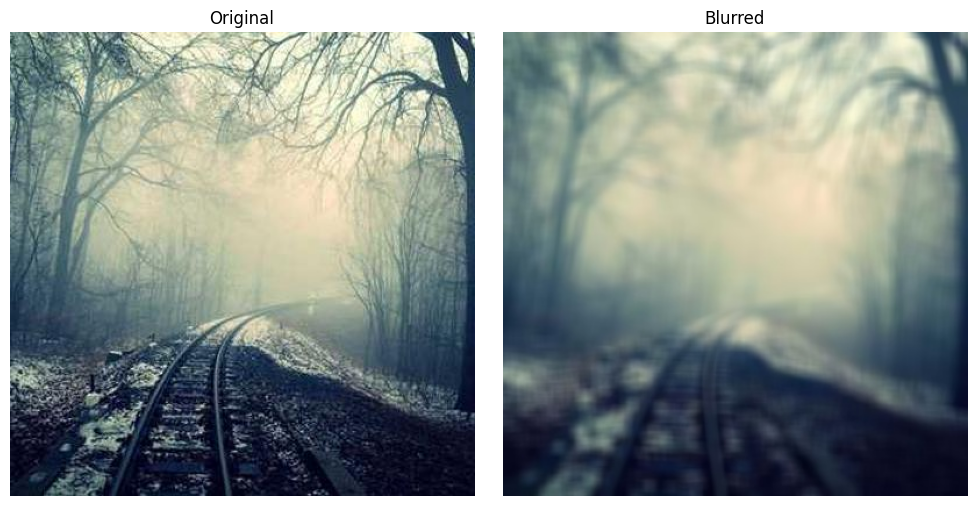

In [22]:
import matplotlib.pyplot as plt
from PIL import Image

# Carga las imágenes "antes.jpg" y "despues.jpg"
img_antes = Image.open("image_1.jpg")
img_despues = Image.open("image_blurred.jpg")

# Crea una figura con dos subplots (uno para cada imagen)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Muestra la imagen "antes" en el primer subplot
axs[0].imshow(img_antes)
axs[0].set_title("Original")
axs[0].axis("off")

# Muestra la imagen "después" en el segundo subplot
axs[1].imshow(img_despues)
axs[1].set_title("Blurred")
axs[1].axis("off")

# Ajusta el diseño y muestra la figura
plt.tight_layout()
plt.show()

### Template Matching

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%cuda --compiler-args "$COMPILER_ARGS"
#include <iostream>
#include <opencv2/opencv.hpp>

__global__ void templateMatching(const uchar* input, const uchar* template_img, float* result, int input_rows, int input_cols, int template_rows, int template_cols) {
    int row = blockIdx.y * blockDim.y + threadIdx.y;
    int col = blockIdx.x * blockDim.x + threadIdx.x;

    if (row < input_rows - template_rows && col < input_cols - template_cols) {
        float sum = 0.0f;
        float input_mean = 0.0f;
        float template_mean = 0.0f;

        // Calcular la media de la imagen de entrada y de la plantilla
        for (int i = 0; i < template_rows; ++i) {
            for (int j = 0; j < template_cols; ++j) {
                input_mean += input[(row + i) * input_cols + (col + j)];
                template_mean += template_img[i * template_cols + j];
            }
        }
        input_mean /= (template_rows * template_cols);
        template_mean /= (template_rows * template_cols);

        // Calcular la correlación cruzada normalizada (NCC)
        for (int i = 0; i < template_rows; ++i) {
            for (int j = 0; j < template_cols; ++j) {
                float input_pixel = input[(row + i) * input_cols + (col + j)];
                float template_pixel = template_img[i * template_cols + j];
                sum += (input_pixel - input_mean) * (template_pixel - template_mean);
            }
        }
        result[row * (input_cols - template_cols) + col] = sum;
    }
}

int main() {
    cv::Mat input_image = cv::imread("/content/drive/MyDrive/template_matching/imagen_a.jpg", cv::IMREAD_GRAYSCALE);
    cv::Mat template_image = cv::imread("/content/drive/MyDrive/template_matching/imagen_b.jpg", cv::IMREAD_GRAYSCALE);

    if (input_image.empty() || template_image.empty()) {
        std::cerr << "Error: No se pudieron cargar las imágenes." << std::endl;
        return 1;
    }

    int input_rows = input_image.rows;
    int input_cols = input_image.cols;
    int template_rows = template_image.rows;
    int template_cols = template_image.cols;

    uchar *d_input, *d_template;
    float *d_result;

    cudaMalloc(&d_input, input_rows * input_cols * sizeof(uchar));
    cudaMalloc(&d_template, template_rows * template_cols * sizeof(uchar));
    cudaMalloc(&d_result, (input_rows - template_rows) * (input_cols - template_cols) * sizeof(float));

    cudaMemcpy(d_input, input_image.data, input_rows * input_cols * sizeof(uchar), cudaMemcpyHostToDevice);
    cudaMemcpy(d_template, template_image.data, template_rows * template_cols * sizeof(uchar), cudaMemcpyHostToDevice);

    dim3 threadsPerBlock(16, 16);
    dim3 numBlocks((input_cols - template_cols + threadsPerBlock.x - 1) / threadsPerBlock.x, (input_rows - template_rows + threadsPerBlock.y - 1) / threadsPerBlock.y);

    templateMatching<<<numBlocks, threadsPerBlock>>>(d_input, d_template, d_result, input_rows, input_cols, template_rows, template_cols);
    cudaDeviceSynchronize();

    float* result = new float[(input_rows - template_rows) * (input_cols - template_cols)];
    cudaMemcpy(result, d_result, (input_rows - template_rows) * (input_cols - template_cols) * sizeof(float), cudaMemcpyDeviceToHost);

    // Encontrar la ubicación de la mejor coincidencia
    float max_val = -FLT_MAX;
    cv::Point best_match;
    for (int i = 0; i < input_rows - template_rows; ++i) {
        for (int j = 0; j < input_cols - template_cols; ++j) {
            if (result[i * (input_cols - template_cols) + j] > max_val) {
                max_val = result[i * (input_cols - template_cols) + j];
                best_match = cv::Point(j, i);
            }
        }
    }

    // Dibujar el recuadro en la imagen de entrada
    cv::rectangle(input_image, best_match, cv::Point(best_match.x + template_cols, best_match.y + template_rows), cv::Scalar(0, 255, 0), 2);

    // Mostrar la imagen con el recuadro

    cv::imwrite("/content/drive/MyDrive/template_matching/image_cuadro.jpg", input_image);
    cv::waitKey(0);
    cv::destroyAllWindows();

    delete[] result;
    cudaFree(d_input);
    cudaFree(d_template);
    cudaFree(d_result);

    return 0;
}
